In [ ]:
%pip install --upgrade pip
%pip install tensorflow
%pip install tensorflow-gpu
%pip install matplotlib
%pip install scipy
%pip install pandas
%pip install opencv_python
%pip install numpy
%pip install scikit-learn

In [1]:
import os

train_path = "../../datasets/personal/clean/64x64/train/"
test_path  = "../../datasets/personal/clean/64x64/test/"

classes = os.listdir(train_path)
classes = sorted(classes)
n_classes = len(classes)
print(f"Classes: {classes}")

input_shape = (64, 64, 3)  # InceptionV3 input size
file_count = []

for fld in os.listdir(train_path):
    crt = os.path.join(train_path, fld)
    image_count = len(os.listdir(crt))
    file_count.append(image_count)
    print(f'{crt} contains {image_count} images')

print(f'\nTotal number of images: {sum(file_count)}')

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
../../datasets/personal/clean/64x64/train/A contains 451 images
../../datasets/personal/clean/64x64/train/B contains 451 images
../../datasets/personal/clean/64x64/train/C contains 451 images
../../datasets/personal/clean/64x64/train/D contains 451 images
../../datasets/personal/clean/64x64/train/E contains 451 images
../../datasets/personal/clean/64x64/train/F contains 451 images
../../datasets/personal/clean/64x64/train/G contains 451 images
../../datasets/personal/clean/64x64/train/I contains 451 images
../../datasets/personal/clean/64x64/train/L contains 451 images
../../datasets/personal/clean/64x64/train/M contains 451 images
../../datasets/personal/clean/64x64/train/N contains 451 images
../../datasets/personal/clean/64x64/train/O contains 451 images
../../datasets/personal/clean/64x64/train/P contains 451 images
../../datasets/personal/clean/64x64/train/Q contains 

In [8]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

# Define channel place
keras.backend.set_image_data_format('channels_last')

## Define constants
BATCH_SIZE = 32
SEED = 123

## Data augmentation and preprocessing
# Training Gen
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=input_shape[:2],
    shuffle=True,
    seed=SEED,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset="training"
)

# Validation Gen
val_data_generator = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input,
)

validation_generator = val_data_generator.flow_from_directory(
    train_path,
    target_size=input_shape[:2],
    shuffle=False,
    seed=SEED,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset="validation"
)

# Test Gen
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)
test_generator = test_generator.flow_from_directory(
    test_path,
    target_size=input_shape[:2],
    shuffle=False,
    seed=SEED,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

## Image quantity
train_samples = train_generator.samples
validation_samples = validation_generator.samples
test_samples = test_generator.samples

Found 7460 images belonging to 21 classes.
Found 1860 images belonging to 21 classes.
Found 5200 images belonging to 21 classes.


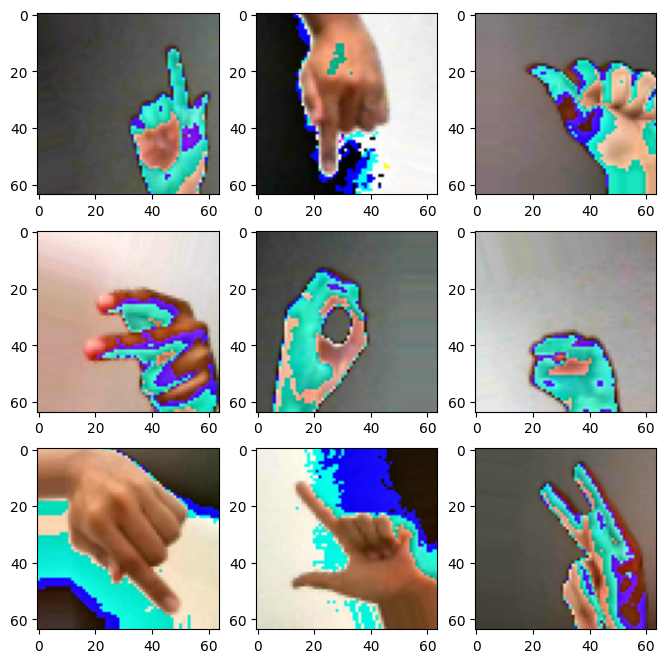

In [9]:
import matplotlib.pyplot as plt

# Visualize Examples
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)

plt.show()

In [4]:
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

# Load the MobileNet model with pre-trained weights (excluding top layers)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freezing layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights('../MobileNet/libras/mobilenet_weights.h5')
model.summary() 

17225924/17225924 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 32, 32, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 32, 32, 32)        288       
 )                                                               
                                                              

In [5]:
EPOCHS = 2
filepath='../MobileNet/personal/'
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=f'{filepath}mobilenet_weights.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=f'{filepath}mobilenet_model.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1,
    ),
]

# Compiling Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Training
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_samples//BATCH_SIZE,
    callbacks = callbacks_list,
    validation_data=validation_generator,
    verbose = 1,
    validation_steps=validation_samples//BATCH_SIZE,
)

Epoch 1/2
233/233 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.8039
Epoch 1: val_accuracy improved from -inf to 0.89978, saving model to ../MobileNet/personal\mobilenet_weights.h5

Epoch 1: val_loss improved from inf to 0.28502, saving model to ../MobileNet/personal\mobilenet_model.h5


c:\Users\Ricardo\Documents\GitHub\Pessoal\TCC\python-tcc\training\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


233/233 [==============================] - 34s 136ms/step - loss: 0.7183 - accuracy: 0.8039 - val_loss: 0.2850 - val_accuracy: 0.8998
Epoch 2/2
233/233 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.9002
Epoch 2: val_accuracy improved from 0.89978 to 0.93211, saving model to ../MobileNet/personal\mobilenet_weights.h5

Epoch 2: val_loss improved from 0.28502 to 0.21947, saving model to ../MobileNet/personal\mobilenet_model.h5
233/233 [==============================] - 28s 122ms/step - loss: 0.3128 - accuracy: 0.9002 - val_loss: 0.2195 - val_accuracy: 0.9321
